In [1]:
# 最常用的RSS程序库
!pip install feedparser
!pip install requests
!pip install jieba
# 定位網頁元件用
!pip install lxml
# 下載繁體字的辭典檔
!git clone https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big
# 文字雲工具
!pip install wordcloud

Cloning into 'dict.txt.big'...
fatal: repository 'https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big/' not found


In [2]:
import json
import feedparser

import requests
from lxml import etree
from io import StringIO
import jieba
import pandas as pd
import time
import random

import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

In [38]:
rss_url = "https://money.udn.com/rssfeed/news/"

In [39]:
newsFeed = feedparser.parse(rss_url)
newsFeed

{'bozo': False,
 'entries': [{'title': '台南買氣轉中古屋 這區房價二年漲近一倍',
   'title_detail': {'type': 'text/plain',
    'language': None,
    'base': 'https://money.udn.com/rssfeed/news/',
    'value': '台南買氣轉中古屋 這區房價二年漲近一倍'},
   'links': [{'rel': 'alternate',
     'type': 'text/html',
     'href': 'https://money.udn.com/money/story/5930/6969685'}],
   'link': 'https://money.udn.com/money/story/5930/6969685',
   'published': 'Tue, 14 Feb 2023 10:07:36 +0800',
   'published_parsed': time.struct_time(tm_year=2023, tm_mon=2, tm_mday=14, tm_hour=2, tm_min=7, tm_sec=36, tm_wday=1, tm_yday=45, tm_isdst=0),
   'summary': '<p><img src="https://pgw.udn.com.tw/gw/photo.php?u=https://uc.udn.com.tw/photo/2023/02/14/realtime/20189411.jpg&amp;s=Y&amp;x=0&amp;y=11&amp;sw=1478&amp;sh=984&amp;sl=W&amp;fw=180&amp;exp=3600" /><p>科技題材與建設題材加持下，台南新屋市場近年表現亮眼，不只買氣熱，房價更是一路狂飆。但現在形勢出現變化。</p>',
   'summary_detail': {'type': 'text/html',
    'language': None,
    'base': 'https://money.udn.com/rssfeed/news/',
    'value': '<p>

In [40]:
i = 1
for e in newsFeed['entries']:
    title = e['title']
    link_url = e['links'][0]['href']
    print("%s, %s, %s"%(i, title, link_url))
    i = i + 1

1, 台南買氣轉中古屋 這區房價二年漲近一倍, https://money.udn.com/money/story/5930/6969685
2, 4飛行物北美上空遭擊落 加總理：顯然有某種模式, https://money.udn.com/money/story/5599/6969684
3, 澎湖就業中心17日徵才活動 26家廠商釋出135個職缺, https://money.udn.com/money/story/11799/6969681
4, 保瑞去年11~12月獲利低於市場預期 跳空跌停、追賣單逾2,000張, https://money.udn.com/money/story/5607/6969680
5, 中美將參與窮國減債圓桌會 本周五首度召開, https://money.udn.com/money/story/5603/6969672
6, 挪威情報機構評估 俄羅斯料將更專制且軍事化, https://money.udn.com/money/story/5599/6969669
7, 台灣精品帶領企業躍升 上銀蔡惠卿出任首位女理事長, https://money.udn.com/money/story/5612/6969670
8, 布局印度好時點 善用RABBIT策略掌契機, https://money.udn.com/money/story/5636/6968944
9, 歷史經驗顯示 Fed最後一次升息布局 Fallen Angel債券指數收穫豐, https://money.udn.com/money/story/5618/6969666
10, 慕尼黑會議期間 日外相林芳正與王毅將「站立交談」, https://money.udn.com/money/story/5603/6969667
11, 股市布局三原則 掌握投資贏面, https://money.udn.com/money/story/5636/6968940
12, 豆豆食品  專業烘培用餡料供應商, https://money.udn.com/money/story/7843/6969651
13, 中國反嗆美國氣球闖領空十幾次！美副國務卿否認：完全沒有, https://money.udn.com/money/story/5599/6969662
14, 資誠印度研討會

In [41]:
# 下載繁體字的辭典檔https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big 
# 指定辭典檔
jieba.set_dictionary('jieba_data/dict.txt.big')

In [42]:
#設定 request header
user_agent =  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36 Edg/109.0.1518.78"

my_headers = {
    'User-Agent': user_agent,
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
    "accept-Language": "zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7",
    "accept-encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "cache-control": "no-cache",
    "Accept-Charset": "UTF8,utf-8;q=0.7,*;q=0.7"
}

In [43]:
#分解動作

#爬文
each_article_text_list = []
for e in newsFeed['entries']:
    url = e['links'][0]['href']
    print(url)
    r = requests.get(url, headers = my_headers)
    if r.status_code == 200:
        parse_tree = etree.parse(StringIO(r.text), etree.HTMLParser())
        # 抓下來的HTML轉成
        # XPath就是一种根据"地址"来"找人"的语言 
        article_elements = parse_tree.xpath('//*[@id="article_body"]//p')
        for a_part in article_elements:
            if type(a_part.text) is str:
                each_article_text_list.append(a_part.text.strip()) # 刮下來文字
        sleep_time = random.randint(3,10)
        print("sleep time: %s sec"%(sleep_time))
        time.sleep(sleep_time)
    all_article_text = ''.join(each_article_text_list)

https://money.udn.com/money/story/5930/6969685
sleep time: 8 sec
https://money.udn.com/money/story/5599/6969684
sleep time: 6 sec
https://money.udn.com/money/story/11799/6969681
sleep time: 7 sec
https://money.udn.com/money/story/5607/6969680
sleep time: 3 sec
https://money.udn.com/money/story/5603/6969672
sleep time: 7 sec
https://money.udn.com/money/story/5599/6969669
sleep time: 9 sec
https://money.udn.com/money/story/5612/6969670
sleep time: 4 sec
https://money.udn.com/money/story/5636/6968944
sleep time: 7 sec
https://money.udn.com/money/story/5618/6969666
sleep time: 9 sec
https://money.udn.com/money/story/5603/6969667
sleep time: 5 sec
https://money.udn.com/money/story/5636/6968940
sleep time: 5 sec
https://money.udn.com/money/story/7843/6969651
sleep time: 10 sec
https://money.udn.com/money/story/5599/6969662
sleep time: 9 sec
https://money.udn.com/money/story/5636/6968939
sleep time: 9 sec
https://money.udn.com/money/story/5599/6969661
sleep time: 4 sec
https://money.udn.com/m

In [10]:
all_article_text

'中共中央政治局委員、中央外事工作委員會辦公室主任王毅13日在北京會見泰國副總理兼外長敦。王毅表示，中方願同泰方攜手落實好訪問成果，深化戰略溝通，加強戰略合作，共同維護兩國正當權益，維護地區和平穩定大局。王毅表示，大陸國家主席習近平去年訪問泰國，為兩國關係未來發展明確前進方向。中泰一家親，兩國人民有著深厚情誼，雙方應像走親戚一樣，常來常往。王毅強調，中泰合作不僅促進了中泰各自發展，中國近期將泰國作為恢復中國公民出境團隊旅遊首批試點國家，泰國副總理兼衛生部長親赴機場歡迎中國遊客，成為中泰友好的真實寫照。王毅說，隨著中國加快疫後復甦，全球最大規模市場優勢充分釋放，內需進一步擴大，中泰人員往來將更加活躍，務實合作將取得更多成果。敦表示，中國超大規模人口邁向現代化將創造人類發展奇跡，並鼓舞和激勵泰國等中小國家加快自身發展進程。去年亞太經合組織領導人非正式會議的成功離不開中方的有力支持和密切協作，也見證了泰中友誼的進一步加深。雙方還就烏克蘭危機等交換了意見。王毅強調，衝突制裁施壓都不是解決辦法，中方將繼續為勸和促談、政治解決發揮建設性作用。櫃買中心為利各項交易新制運作順暢及推廣櫃買市場相關商品，自2016年起與證券商合作舉辦櫃買市場投資人講座，講座透過不同課程的設計及邀請不同專業背景的講師，就國內外經濟情勢與產業展望、從國際政經情勢看台股投資戰略及櫃買市場交易新制介紹等多樣性主題進行專題演講，因此，自開辦以來，深受投資人喜愛，今(2023)年度的首場講座即將在3月17日登場。櫃買中心表示，今年度除依往例與多家證券商(包含大昌證券、元大證券、元富證券、兆豐證券、統一證券、富邦證券、華南永昌證券等七家證券商)合作舉辦講座外，另為擴大宣傳層面，特別再與元大及中信等2家投信公司合作，共計於北中南各地舉辦24場次，這次投資講座內容相當豐富，各場次均邀請知名專業講師解析國際經濟情勢及台股市場投資展望等相關議題，另為提升投資人對指數化商品的投資概念，部分場次特別安排指數商品投資相關主題的專題演講，對於有意進行更廣泛及多元的資產配置的投資人，將會有很大的助益。投資講座相關場次資訊，櫃買中心已於該中心網站公布，內容精彩可期。櫃買中心表示，為提供投資人多元的參加方式，台北場次均同步採網路線上影音直播及部分場次錄製影音檔，歡迎投資人至該中心網站首頁點選連結觀看。有關櫃買投資人講座場次時間、地點及專

In [52]:
# save raw_text_data as txt
with open("text_freq.txt",'w') as f:
    seg_words_str = "".join(all_article_text)
    f.write(seg_words_str)

In [54]:
# 讀取raw_text_data
with open("text_freq.txt",'r') as f:
    seg_words_list = f.read()
    
seg_words_list

"科技題材與建設題材加持下，台南新屋市場近年表現亮眼，不只買氣熱，房價更是一路狂飆。但現在形勢出現變化。東森房屋統計內政部不動產資訊平台資訊，去年Q3，台南屋齡5年以下之新成屋交易佔比僅為16.5%，較前一年重滑8個百分點，也創下2010年以來，12年來同期新低。東森房屋研究中心經理葉沛堯表示，數據顯示，台南新推案價格屢創新高，已使新成屋交易逐漸降溫，買氣逐漸向中古屋轉移，也帶動中古屋房價明顯上揚。觀察實價資料，台南主要行政區中古屋市場的表現，近兩年以善化區中古屋房價上漲94%最多，價格幾乎翻了一倍，其次分別是南區53%、永康區51%，安平區39%。東森房屋台南金華加盟店店長鄭勝陽表示，善化區緊鄰南科，就業人口的持續流入帶動當地的居住需求不斷增加，而且善化區還有LM特定區等建設項目為區域房市增添亮點，區內中古屋的平均房價短短兩年就從1字頭跳上2字頭，漲勢驚人。永康區的建設題材相當豐沛，又可以共享台南蛋黃區的基礎機能，目前永康已有個別預售案的開價跳上4字頭，中古屋也基本都有2字頭的水準，顯見普通民眾的買房門檻愈來愈高。至於南區，鄭勝陽指出，過去南區受嫌惡設施影響，如南山公墓，導致區域房價行情一直都在較低檔位，最近幾年政府開始積極改善南區的居住環境，加上舉喜重劃區與水交社重劃區的建設，讓南區房市能見度快速提升，區域房價也水漲船高。他表示，由於南區具有房價基期低的先天優勢，即使區域房價飆漲，目前南區中古屋的價格仍普遍落在1字頭，相較於南市其他精華區而言，南區房價的確很有競爭力。此外，隨著台積電的發展與蛋黃區人口外溢，南區房價仍有落後補漲的動能，購屋民眾值得留意。葉沛堯表示，台南房市長線不看淡，但短期內房價漲勢過快，加上房價已經站在歷史高點，民眾進場前應做好風險評估，避免追高，同時盡量避開政策調控的重點產品，如要價過高的預售屋、新成屋，以降低未來被套牢的風險。加拿大總理杜魯道今天表示，最近幾天遭擊落的4個物體，包括11日在育空地區（Yukon Territory）上空擊落的物體，某種程度上存在關連；但他並未詳細說明。路透社報導，杜魯道（Justin Trudeau）在育空地區首府白馬（Whitehorse）舉行的記者會上表示：「顯然存在某種模式，過去一週我們在很大程度上看到了這一點，這引起人們的興趣和密切關注。」一枚疑似中國間諜氣球飛越美國上空，2月4日在南卡羅來納州海岸遭

In [58]:
#stop word
with open(file='jieba_data/stop_words.txt', mode='r', encoding='utf-8') as file:
    stop_words = file.read().split('\n')
stop_words

['the',
 'of',
 'is',
 'and',
 'to',
 'in',
 'that',
 'we',
 'for',
 'an',
 'are',
 'by',
 'be',
 'as',
 'on',
 'with',
 'can',
 'if',
 'from',
 'which',
 'you',
 'it',
 'this',
 'then',
 'at',
 'have',
 'all',
 'not',
 'one',
 'has',
 'or',
 'that',
 '的',
 '了',
 '和',
 '是',
 '就',
 '都',
 '而',
 '及',
 '與',
 '著',
 '或',
 '一個',
 '沒有',
 '我們',
 '你們',
 '妳們',
 '他們',
 '她們',
 '是否',
 '、',
 ',',
 '，',
 '',
 '。',
 '在',
 '也',
 '等',
 '「',
 '」',
 '表示',
 '月',
 '為',
 '台灣',
 '有',
 '年',
 '發展',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '0',
 '會',
 '更',
 '到指出',
 '超過',
 '中',
 '，',
 '並',
 '將',
 '透過',
 '讓',
 '.',
 ',',
 '(',
 ')',
 '[',
 ']',
 '日',
 '度',
 '後',
 '包括',
 '但',
 '點',
 ';',
 '()',
 '市',
 '期',
 '仍',
 '去年',
 '億美元',
 '']

In [59]:
#分詞
seg_stop_words_list = []
seg_words_list = jieba.lcut(all_article_text)

seg_words_list

['科技',
 '題材',
 '與',
 '建設',
 '題材',
 '加持',
 '下',
 '，',
 '台南',
 '新屋',
 '市場',
 '近年',
 '表現',
 '亮眼',
 '，',
 '不',
 '只',
 '買氣',
 '熱',
 '，',
 '房價',
 '更是',
 '一路',
 '狂飆',
 '。',
 '但',
 '現在',
 '形勢',
 '出現',
 '變化',
 '。',
 '東森',
 '房屋',
 '統計',
 '內政部',
 '不動產',
 '資訊',
 '平台',
 '資訊',
 '，',
 '去年',
 'Q3',
 '，',
 '台南',
 '屋齡',
 '5',
 '年',
 '以下',
 '之新',
 '成屋',
 '交易',
 '佔',
 '比僅',
 '為',
 '16.5%',
 '，',
 '較前',
 '一年',
 '重滑',
 '8',
 '個',
 '百分點',
 '，',
 '也',
 '創下',
 '2010',
 '年',
 '以來',
 '，',
 '12',
 '年來',
 '同期',
 '新低',
 '。',
 '東森',
 '房屋',
 '研究',
 '中心',
 '經理',
 '葉沛堯',
 '表示',
 '，',
 '數據',
 '顯示',
 '，',
 '台南',
 '新',
 '推案',
 '價格',
 '屢',
 '創新',
 '高',
 '，',
 '已',
 '使',
 '新',
 '成屋',
 '交易',
 '逐漸',
 '降溫',
 '，',
 '買氣',
 '逐漸',
 '向',
 '中',
 '古屋',
 '轉移',
 '，',
 '也',
 '帶動',
 '中',
 '古屋',
 '房價',
 '明顯',
 '上揚',
 '。',
 '觀察',
 '實價',
 '資料',
 '，',
 '台南',
 '主要',
 '行政區',
 '中',
 '古屋',
 '市場',
 '的',
 '表現',
 '，',
 '近兩年',
 '以',
 '善化',
 '區中',
 '古屋',
 '房價',
 '上漲',
 '94%',
 '最多',
 '，',
 '價格',
 '幾乎',
 '翻',
 '了',
 '一倍',
 '，',
 '其次',
 '分別',
 '是',
 '南

In [72]:
# 去除禁用字詞
for term in seg_words_list:
    if term not in stop_words:
        seg_stop_words_list.append(term)


# 以空白區隔文字
seg_words = ' '.join(seg_words_list)

seg_words

"科技 題材 與 建設 題材 加持 下 ， 台南 新屋 市場 近年 表現 亮眼 ， 不 只 買氣 熱 ， 房價 更是 一路 狂飆 。 但 現在 形勢 出現 變化 。 東森 房屋 統計 內政部 不動產 資訊 平台 資訊 ， 去年 Q3 ， 台南 屋齡 5 年 以下 之新 成屋 交易 佔 比僅 為 16.5% ， 較前 一年 重滑 8 個 百分點 ， 也 創下 2010 年 以來 ， 12 年來 同期 新低 。 東森 房屋 研究 中心 經理 葉沛堯 表示 ， 數據 顯示 ， 台南 新 推案 價格 屢 創新 高 ， 已 使 新 成屋 交易 逐漸 降溫 ， 買氣 逐漸 向 中 古屋 轉移 ， 也 帶動 中 古屋 房價 明顯 上揚 。 觀察 實價 資料 ， 台南 主要 行政區 中 古屋 市場 的 表現 ， 近兩年 以 善化 區中 古屋 房價 上漲 94% 最多 ， 價格 幾乎 翻 了 一倍 ， 其次 分別 是 南區 53% 、 永康 區 51% ， 安平 區 39% 。 東森 房屋 台南 金華 加盟店 店長 鄭勝陽 表示 ， 善化 區 緊鄰 南科 ， 就業人口 的 持續 流入 帶動 當地 的 居住 需求 不斷 增加 ， 而且 善化 區 還有 LM 特定 區等 建設項目 為 區域 房市 增添 亮點 ， 區內 中 古屋 的 平均 房價 短短 兩年 就 從 1 字頭 跳上 2 字頭 ， 漲勢 驚人 。 永康 區的 建設 題材 相當 豐沛 ， 又 可以 共享 台南 蛋黃 區的 基礎 機能 ， 目前 永康 已有 個別 預售 案 的 開價 跳上 4 字頭 ， 中 古屋 也 基本 都 有 2 字頭 的 水準 ， 顯見 普通 民眾 的 買房 門檻 愈來愈 高 。 至於 南區 ， 鄭勝陽 指出 ， 過去 南區 受 嫌惡 設施 影響 ， 如 南山 公墓 ， 導致 區域 房價 行情 一直 都 在 較 低檔 位 ， 最近 幾年 政府 開始 積極 改善 南區 的 居住 環境 ， 加上 舉喜 重劃 區與 水交社 重劃 區的 建設 ， 讓 南區 房市 能見度 快速 提升 ， 區域 房價 也 水漲船高 。 他 表示 ， 由於 南區 具有 房價 基期 低 的 先天 優勢 ， 即使 區域 房價 飆漲 ， 目前 南區 中 古屋 的 價格 仍 普遍 落 在 1 字頭 ， 相較 於 南市 其他 精華區 而言 ， 南區

In [73]:
# 準備一個有經過stop word 處理的 counter
seg_stop_counter = Counter(seg_stop_words_list)

In [74]:
seg_stop_counter_dict = dict(seg_stop_counter)

seg_stop_counter_dict

{'科技': 20,
 '題材': 12,
 '建設': 12,
 '加持': 4,
 '下': 28,
 '台南': 28,
 '新屋': 4,
 '市場': 84,
 '近年': 4,
 '表現': 32,
 '亮眼': 4,
 '不': 32,
 '只': 8,
 '買氣': 8,
 '熱': 4,
 '房價': 48,
 '更是': 4,
 '一路': 4,
 '狂飆': 4,
 '現在': 8,
 '形勢': 4,
 '出現': 24,
 '變化': 8,
 '東森': 12,
 '房屋': 12,
 '統計': 4,
 '內政部': 4,
 '不動產': 4,
 '資訊': 36,
 '平台': 4,
 'Q3': 4,
 '屋齡': 4,
 '以下': 4,
 '之新': 4,
 '成屋': 8,
 '交易': 16,
 '佔': 4,
 '比僅': 4,
 '16.5%': 4,
 '較前': 4,
 '一年': 8,
 '重滑': 4,
 '個': 40,
 '百分點': 4,
 '創下': 8,
 '2010': 4,
 '以來': 40,
 '12': 48,
 '年來': 4,
 '同期': 8,
 '新低': 4,
 '研究': 4,
 '中心': 20,
 '經理': 4,
 '葉沛堯': 8,
 '數據': 8,
 '顯示': 12,
 '新': 24,
 '推案': 4,
 '價格': 32,
 '屢': 8,
 '創新': 12,
 '高': 16,
 '已': 32,
 '使': 8,
 '逐漸': 16,
 '降溫': 4,
 '向': 8,
 '古屋': 28,
 '轉移': 4,
 '帶動': 16,
 '明顯': 16,
 '上揚': 4,
 '觀察': 4,
 '實價': 4,
 '資料': 8,
 '主要': 24,
 '行政區': 4,
 '近兩年': 8,
 '以': 52,
 '善化': 12,
 '區中': 4,
 '上漲': 8,
 '94%': 4,
 '最多': 4,
 '幾乎': 4,
 '翻': 4,
 '一倍': 4,
 '其次': 4,
 '分別': 20,
 '南區': 36,
 '53%': 4,
 '永康': 12,
 '區': 20,
 '51%': 4,
 '安平': 4,
 '39%'

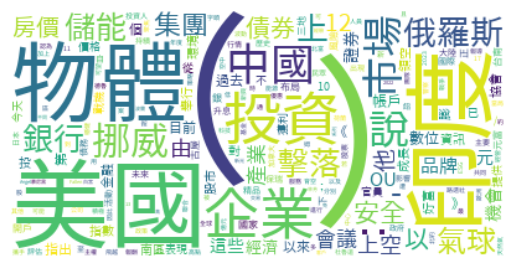

In [75]:
#有處理stop words
wordcloud = WordCloud(font_path='fonts/TaipeiSansTCBeta-Regular.ttf',background_color="white").generate_from_frequencies(seg_stop_counter)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()